In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

import bilby
import pycbc
import pickle
import deepdish
import pycbc.psd
import pycbc.types
import gwpopulation
import pycbc.waveform 
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
from matplotlib.colors import ListedColormap
from glob import glob
from tqdm import tqdm
from copy import deepcopy
from pycbc.frame import read_frame
import gwmat

import lalsimulation

import pycbc.waveform as waveform
from pycbc.waveform.utils import taper_timeseries

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines")
rc('axes', labelsize=25) #24
rc("axes") #2)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)
rc('legend', fontsize=20) #16
rc('ytick', right='True',direction= 'in')
rc('xtick', top='True',direction= 'in')
rc('xtick.major', pad=15) #8)
rc('ytick.major', pad=15) #8)
rc('xtick.major', size=12) #8)
rc('ytick.major', size=12) #8)
rc('xtick.minor', size=7) #8)
rc('ytick.minor', size=7) #8)
rc('figure', titlesize=27) #24)
rc('axes', labelpad=10) #24)

def set_tick_sizes(ax, major, minor):
    for l in ax.get_xticklines() + ax.get_yticklines():
        l.set_markersize(major)
    for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
        tick.tick1line.set_markersize(minor)
        tick.tick2line.set_markersize(minor)
    ax.xaxis.LABELPAD=10.
    ax.xaxis.OFFSETTEXTPAD=10.

In [3]:
delta_f = 1
duration = 100
minimum_frequency = 20
reference_frequency = 50   # Most sensitive frequency
maximum_frequency = 16384/2
sampling_frequency = 16384
delta_t = 1/sampling_frequency

In [4]:
### Different methods to generate Overlapping signals
def generate_overlapping_signals_v1(d_1, d_2, **kwargs):
    default_kwargs = {"wf_domain":"TD", "approximant":"IMRPhenomXPHM", "rwrap":-0.2, "delta_t":1/4096, 
                      "taper_hp_hc":True, "hp_hc_extra_padding_at_start":8}
    default_kwargs.update(kwargs)
    kwargs = default_kwargs.copy()
    d_1.update(kwargs)
    d_2.update(kwargs)
    wfs_res_1 = gwmat.injection.simulate_injection_with_comprehensive_output(**d_1)
    wfs_res_2 = gwmat.injection.simulate_injection_with_comprehensive_output(**d_2)
    singles_1, singles_2 = {}, {}
    overlapping_signal = {}
    for ifo in wfs_res_1["pure_ifo_signal"].keys():
        singles_1[ifo] = wfs_res_1["pure_ifo_signal"][ifo]
        singles_2[ifo] = wfs_res_2["pure_ifo_signal"][ifo]
        dt = float(singles_2[ifo].start_time) - float(singles_1[ifo].start_time)
        if dt > 0: 
            singles_2[ifo] = gwmat.injection.modify_signal_start_time(singles_2[ifo], extra = dt)
        if dt < 0: 
            singles_1[ifo] = gwmat.injection.modify_signal_start_time(singles_1[ifo], extra = abs(dt))    
        overlapping_signal[ifo] = singles_1[ifo] + singles_2[ifo]
    return singles_1, singles_2, overlapping_signal 

def generate_overlapping_signals_v2(d_1, d_2, **kwargs):
    default_kwargs = {"wf_domain":"FD", "approximant":"IMRPhenomXPHM", "delta_f":1/4, 
                      "f_final":2048, "rwrap":-0.3}
    default_kwargs.update(kwargs)
    kwargs = default_kwargs.copy()
    d_1.update(kwargs)
    d_2.update(kwargs)
    wfs_res_1 = gwmat.injection.simulate_injection_with_comprehensive_output(**d_1)
    wfs_res_2 = gwmat.injection.simulate_injection_with_comprehensive_output(**d_2)
    singles_1, singles_2 = {}, {}
    overlapping_signal = {}
    for ifo in wfs_res_1["pure_ifo_signal"].keys():
        singles_1[ifo] = wfs_res_1["pure_ifo_signal"][ifo]
        singles_2[ifo] = wfs_res_2["pure_ifo_signal"][ifo]
        overlapping_signal[ifo] = singles_1[ifo] + singles_2[ifo]
    return singles_1, singles_2, overlapping_signal  


# def project_onto_detector(fd_hp, fd_hc, **params):
#     from pycbc.detector import Detector
#     projected_signal={}
#     for ifo in params["ifo_list"]:
#         detector = Detector(ifo)
#         ifo_timedelay = detector.time_delay_from_earth_center(params["ra"], params["dec"], params["geocent_time"])
#         shifted_hp = deepcopy(fd_hp)
#         shifted_hc = deepcopy(fd_hc)
#         shifted_hp.start_time += ifo_timedelay
#         shifted_hc.start_time += ifo_timedelay
#         Fp, Fc = detector.antenna_pattern(params["ra"], params["dec"], params["polarization"], params["geocent_time"])
#         proj_hp = Fp * shifted_hp
#         proj_hc = Fc * shifted_hc
#         projected_signal[ifo] = proj_hp + proj_hc
#     return projected_signal

def project_onto_detector(fd_hp, fd_hc, **params):
    from pycbc.detector import Detector
    projected_signal={}
    for ifo in params["ifo_list"]:
        detector = Detector(ifo)
        ifo_timedelay = detector.time_delay_from_earth_center(params["ra"], params["dec"], params["geocent_time"])
        # total_t_shift = params["geocent_time"] + ifo_timedelay
        shifted_hp = deepcopy(fd_hp)
        shifted_hc = deepcopy(fd_hc)
        shifted_hp.start_time += params["geocent_time"] 
        shifted_hc.start_time += params["geocent_time"] 
        Fp, Fc = detector.antenna_pattern(params["ra"], params["dec"], params["polarization"], params["geocent_time"])
        proj_hp = Fp * shifted_hp
        proj_hc = Fc * shifted_hc
        projected_signal[ifo] = proj_hp + proj_hc
        projected_signal[ifo].start_time += ifo_timedelay
    return projected_signal    

def generate_overlapping_signals_v3(d_1, d_2, **kwargs):
    default_kwargs = {"wf_domain":"FD", "approximant":"IMRPhenomXPHM", "delta_f":1/16, 
                      "f_final":2048, "rwrap":-2.1, "ifo_list":["H1"]}
    default_kwargs.update(kwargs)
    kwargs = default_kwargs.copy()
    d_1.update(kwargs)
    d_2.update(kwargs)
    d_1 = gwmat.gw_utils.sync_bilby_and_pycbc_keys(**d_1)
    d_2 = gwmat.gw_utils.sync_bilby_and_pycbc_keys(**d_2)
    
    hp1, hc1 = pycbc.waveform.get_fd_waveform(**d_1)
    projected_signals_1 = project_onto_detector(hp1, hc1, **d_1)
    
    hp2, hc2 = pycbc.waveform.get_fd_waveform(**d_2)
    projected_signals_2 = project_onto_detector(hp2, hc2, **d_2)

    overlapping_signal = {}
    for ifo in d_1["ifo_list"]:
        overlapping_signal[ifo] = projected_signals_1[ifo] + projected_signals_2[ifo]
        overlapping_signal[ifo] = overlapping_signal[ifo].to_timeseries(delta_t=overlapping_signal[ifo].delta_t)
        overlapping_signal[ifo] = overlapping_signal[ifo].cyclic_time_shift(kwargs["rwrap"])
    return projected_signals_1, projected_signals_2, overlapping_signal      

In [5]:
def plot(inj_num):
    inj_dir="../../output/pe_population/injections/"
    ifo="H1"
    def_kwargs = {"approximant":"IMRPhenomXO4a", "rwrap":-0.3, "delta_t":1/4096, 
                        "taper_hp_hc":True, "hp_hc_extra_padding_at_start":8.0, "delta_f":1/32, 
                        "f_final":2048}
    kwargs = deepcopy(def_kwargs)
    new_injs_path = glob(inj_dir + "PAIRS*_"+ifo+"_*.gwf")
    f=new_injs_path[inj_num]
    inj_label = f.split("/PAIRS_"+ifo)[-1].split(".gwf")[0]
    inj_pair = read_frame(location=f, channels=ifo+":PyCBC_Injection")

    f_1 = glob("../../output/pe_population/injections/SINGLES_A"+inj_label+".npy")[0]
    d_1 = np.load(f_1, allow_pickle=True).item()
    f_2 = glob("../../output/pe_population/injections/SINGLES_B"+inj_label+".npy")[0]
    d_2 = np.load(f_2, allow_pickle=True).item()

    singles_1_v1, singles_2_v1, pairs_gwmat_v1 = generate_overlapping_signals_v1(d_1, d_2, **kwargs)
    kwargs.update(rwrap=-2.1)
    singles_1_v2, singles_2_v2, pairs_gwmat_v2 = generate_overlapping_signals_v2(d_1, d_2, **kwargs)  
    singles_1_v3, singles_2_v3, pairs_gwmat_v3 = generate_overlapping_signals_v3(d_1, d_2, **kwargs)

    injection_parameters_a = np.load(f_1, allow_pickle=True).item()
    injection_parameters_b = np.load(f_2, allow_pickle=True).item()
    start_time = injection_parameters_a['geocent_time']-duration+2

    def wf_len_mod_start(wf, extra=1, **prms):
        """
        Taken from GWMAT. Function to modify the starting of a WF so that it starts on an integer GPS time (in sec) + add extra length as specified by the user.

        Parameters
        ----------
        wf :  pycbc.types.TimeSeries
            WF whose length is to be modified.
        extra : int, optional
            Extra length to be added in the beginning after making the WF to start from an integer GPS time (in sec). Default = 1.

        Returns
        -------
        pycbc.types.timeseries.TimeSeries
            Modified waveform starting form an integer time.

        """      

        olen = len(wf)   
        diff = wf.sample_times[0]-np.floor(wf.sample_times[0])  
        #nlen = round(olen+sampling_frequency*(extra+diff))
        dlen = round(sampling_frequency*(extra+diff))
        wf_strain = np.concatenate((np.zeros(dlen), wf))
        t0 = wf.sample_times[0]
        dt = wf.delta_t
        n = dlen
        tnn = t0-(n+1)*dt
        wf_stime = np.concatenate((np.arange(t0-dt,tnn,-dt)[::-1], np.array(wf.sample_times)))
        nwf = pycbc.types.TimeSeries(wf_strain, delta_t=wf.delta_t, epoch=wf_stime[0])
        
        return nwf

    def wf_len_mod_end(wf, extra=2, **prms): #post_trig_duration
        """
        Taken from GWMAT. Function to modify the end of a WF so that it ends on an integer GPS time (in sec) + add extra length as specified by the user.

        Parameters
        ----------
        wf : pycbc.types.TimeSeries
            WF whose length is to be modified.
        extra : int, optional
            Extra length to be added towards the end after making the WF to end from an integer GPS time (in sec). 
            Default = 2, which makes sure post-trigger duration is of at least 2 seconds.

        Returns
        -------
        pycbc.types.timeseries.TimeSeries
            Modified waveform ending on an integer time.

        """        

        olen = len(wf)   
        dt = abs(wf.sample_times[-1] - wf.sample_times[-2])
        diff = np.ceil(wf.sample_times[-1]) - (wf.sample_times[-1] + dt)   #wf.sample_times[-1]-int(wf.sample_times[-1])  
        nlen = round(olen + sampling_frequency*(extra+diff))
        wf.resize(nlen)
        
        return wf    

    def make_len_power_of_2(wf):
        """
        Taken from GWMAT. Function to modify the length of a waveform so that its duration is a power of 2.

        Parameters
        ----------
        wf : pycbc.types.TimeSeries
            WF whose length is to be modified.
            Modified waveform with duration a power of 2.
        Returns
        -------
        pycbc.types.timeseries.TimeSeries
            Returns the waveform with length a power of 2.

        """    

        dur = wf.duration  
        wf.resize( int(round(wf.sample_rate * np.power(2, np.ceil( np.log2( dur ) ) ))) )
        wf = cyclic_time_shift_of_WF(wf, rwrap = wf.duration - dur )
        
        return wf    

    def cyclic_time_shift_of_WF(wf, rwrap=0.2):
        """
        Taken from GWMAT. Inspired by PyCBC's function pycbc.types.TimeSeries.cyclic_time_shift(), 
            it shifts the data and timestamps in the time domain by a given number of seconds (rwrap). 
            Difference between this and PyCBCs function is that this function preserves the sample rate of the WFs while cyclically rotating, 
            but the time shift cannot be smaller than the intrinsic sample rate of the data, unlike PyCBc's function.
            To just change the time stamps, do ts.start_time += dt.
            Note that data will be cyclically rotated, so if you shift by 2
            seconds, the final 2 seconds of your data will now be at the
            beginning of the data set.

        Parameters
        ----------
        wf : pycbc.types.TimeSeries
            The waveform for cyclic rotation.
        rwrap : float, optional
            Amount of time to shift the vector. Default = 0.2.

        Returns
        -------
        pycbc.types.TimeSeries
            The time shifted time series.

        """        

        # This function does cyclic time shift of a WF.
        # It is similar to PYCBC's "cyclic_time_shift" except for the fact that it also preserves the Sample Rate of the original WF.
        if rwrap is not None and rwrap != 0:
            sn = abs(int(rwrap/wf.delta_t))     # number of elements to be shifted 
            cycles = int(sn/len(wf))

            cyclic_shifted_wf = wf.copy()

            sn_new = sn - int(cycles * len(wf))

            if rwrap > 0:
                epoch = wf.sample_times[0] - sn_new * wf.delta_t
                if sn_new != 0:
                    wf_arr = np.array(wf).copy()
                    tmp_wf_p1 = wf_arr[-sn_new:]
                    tmp_wf_p2 = wf_arr[:-sn_new] 
                    shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                    cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)
            else:
                epoch = wf.sample_times[sn_new]
                if sn_new != 0:
                    wf_arr = np.array(wf).copy()
                    tmp_wf_p1 = wf_arr[sn_new:] 
                    tmp_wf_p2 = wf_arr[:sn_new]
                    shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                    cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)  

            for i in range(cycles):        
                    epoch = epoch - np.sign(rwrap)*wf.duration
                    wf_arr = np.array(cyclic_shifted_wf)[:]
                    cyclic_shifted_wf = pycbc.types.TimeSeries(wf_arr, delta_t = wf.delta_t, epoch = epoch)

            assert len(cyclic_shifted_wf) == len(wf), 'Length mismatch: cyclic time shift added extra length to WF.'
            return cyclic_shifted_wf
        else:
            return wf  

    def jframe_to_l0frame(mass_1, mass_2, reference_frequency, phi_ref=0., theta_jn=0., phi_jl=0., a_1=0., a_2=0., tilt_1=0., tilt_2=0., phi_12=0., **kwargs):  
        """
        [Inherited from PyCBC and lalsimulation.]
            Function to convert J-frame coordinates (which Bilby uses for PE) to L0-frame coordinates (that Pycbc uses for waveform generation).
            J stands for the total angular momentum while L0 stands for the orbital angular momentum.
        """ 

        inclination, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z = \
            lalsimulation.SimInspiralTransformPrecessingNewInitialConditions(
                theta_jn, phi_jl, tilt_1, tilt_2, phi_12,
                a_1, a_2, mass_1*lal.MSUN_SI, mass_2*lal.MSUN_SI, reference_frequency,
                phi_ref)
        out_dict = {'inclination': inclination,
                    'spin1x': spin1x,
                    'spin1y': spin1y,
                    'spin1z': spin1z,
                    'spin2x': spin2x,
                    'spin2y': spin2y,
                    'spin2z': spin2z}
        return out_dict

    lframe_a = jframe_to_l0frame(mass_1=injection_parameters_a['mass_1'], 
                                mass_2=injection_parameters_a['mass_2'], 
                                reference_frequency=reference_frequency, 
                                theta_jn=injection_parameters_a['theta_jn'], 
                                phi_jl=injection_parameters_a['phi_jl'], 
                                a_1=injection_parameters_a['a_1'], 
                                a_2=injection_parameters_a['a_2'], 
                                tilt_1=injection_parameters_a['tilt_1'], 
                                tilt_2=injection_parameters_a['tilt_2'], 
                                phi_12=injection_parameters_a['phi_12'])   

    waveform_params_a = {
        'approximant': 'IMRPhenomXO4a',
        'mass1': injection_parameters_a['mass_1'],
        'mass2': injection_parameters_a['mass_2'],
        'spin1x': lframe_a['spin1x'],
        'spin1y': lframe_a['spin1y'],
        'spin1z': lframe_a['spin1z'],
        'spin2x': lframe_a['spin2x'],
        'spin2y': lframe_a['spin2y'],
        'spin2z': lframe_a['spin2z'],
        'distance': injection_parameters_a['luminosity_distance'],
        'inclination': lframe_a['inclination'],
        'coa_phase': injection_parameters_a['phase'],
        'f_lower': minimum_frequency,
        'f_ref': reference_frequency,
        'delta_t': delta_t
    }

    lframe_b = jframe_to_l0frame(mass_1=injection_parameters_b['mass_1'],
                                mass_2=injection_parameters_b['mass_2'],
                                reference_frequency=reference_frequency,
                                theta_jn=injection_parameters_b['theta_jn'],
                                phi_jl=injection_parameters_b['phi_jl'],
                                a_1=injection_parameters_b['a_1'],
                                a_2=injection_parameters_b['a_2'],
                                tilt_1=injection_parameters_b['tilt_1'],
                                tilt_2=injection_parameters_b['tilt_2'],
                                phi_12=injection_parameters_b['phi_12'])

    waveform_params_b = {
        'approximant': 'IMRPhenomXO4a',
        'mass1': injection_parameters_b['mass_1'],
        'mass2': injection_parameters_b['mass_2'],
        'spin1x': lframe_b['spin1x'],
        'spin1y': lframe_b['spin1y'],
        'spin1z': lframe_b['spin1z'],
        'spin2x': lframe_b['spin2x'],
        'spin2y': lframe_b['spin2y'],
        'spin2z': lframe_b['spin2z'],
        'distance': injection_parameters_b['luminosity_distance'],
        'inclination': lframe_b['inclination'],
        'coa_phase': injection_parameters_b['phase'],
        'f_lower': minimum_frequency,
        'f_ref': reference_frequency,
        'delta_t': delta_t
    }

    det, ifo_signal_a, ifo_signal_b = dict(), dict(), dict()
    for ifo in ['H1', 'L1', 'V1']:
        det[ifo] = pycbc.detector.Detector(ifo)

        hp_a, hc_a = waveform.get_td_waveform(**waveform_params_a)
        hp_a.start_time += injection_parameters_a['geocent_time']
        hc_a.start_time += injection_parameters_a['geocent_time']

        ifo_signal_a[ifo] = det[ifo].project_wave(hp_a, hc_a, injection_parameters_a['ra'], injection_parameters_a['dec'], injection_parameters_a['psi'])
        ifo_signal_a[ifo] = taper_timeseries(ifo_signal_a[ifo], tapermethod='TAPER_STARTEND', return_lal=False)
        ifo_signal_a[ifo] = make_len_power_of_2(wf_len_mod_end(wf_len_mod_start(ifo_signal_a[ifo])))
        
        hp_b, hc_b = waveform.get_td_waveform(**waveform_params_b)
        hp_b.start_time += injection_parameters_b['geocent_time']
        hc_b.start_time += injection_parameters_b['geocent_time']

        ifo_signal_b[ifo] = det[ifo].project_wave(hp_b, hc_b, injection_parameters_b['ra'], injection_parameters_b['dec'], injection_parameters_b['psi'])
        ifo_signal_b[ifo] = taper_timeseries(ifo_signal_b[ifo], tapermethod='TAPER_STARTEND', return_lal=False)
        ifo_signal_b[ifo] = make_len_power_of_2(wf_len_mod_end(wf_len_mod_start(ifo_signal_b[ifo])))

    ht_H1_a, ht_L1_a, ht_V1_a = ifo_signal_a['H1'], ifo_signal_a['L1'], ifo_signal_a['V1']
    ht_H1_b, ht_L1_b, ht_V1_b = ifo_signal_b['H1'], ifo_signal_b['L1'], ifo_signal_b['V1']
    ht_a, ht_b = {'H1': ht_H1_a, 'L1': ht_L1_a, 'V1': ht_V1_a}, {'H1': ht_H1_b, 'L1': ht_L1_b, 'V1': ht_V1_b}

    delta_f = np.min([ht_H1_a.delta_f, ht_L1_a.delta_f, ht_V1_a.delta_f, ht_H1_b.delta_f, ht_L1_b.delta_f, ht_V1_b.delta_f])
    hf_a_H1, hf_a_L1, hf_a_V1 = ht_H1_a.to_frequencyseries(delta_f=delta_f), ht_L1_a.to_frequencyseries(delta_f=delta_f), ht_V1_a.to_frequencyseries(delta_f=delta_f)
    hf_b_H1, hf_b_L1, hf_b_V1 = ht_H1_b.to_frequencyseries(delta_f=delta_f), ht_L1_b.to_frequencyseries(delta_f=delta_f), ht_V1_b.to_frequencyseries(delta_f=delta_f)

    hf_H1 = hf_a_H1 + hf_b_H1 * np.exp(-1j * 2 * np.pi * (hf_b_H1.epoch.gpsSeconds + hf_b_H1.epoch.gpsNanoSeconds * 1e-9 - hf_a_H1.epoch.gpsSeconds - hf_a_H1.epoch.gpsNanoSeconds * 1e-9) * hf_b_H1.sample_frequencies)
    hf_L1 = hf_a_L1 + hf_b_L1 * np.exp(-1j * 2 * np.pi * (hf_b_L1.epoch.gpsSeconds + hf_b_L1.epoch.gpsNanoSeconds * 1e-9 - hf_a_L1.epoch.gpsSeconds - hf_a_L1.epoch.gpsNanoSeconds * 1e-9) * hf_b_L1.sample_frequencies)
    hf_V1 = hf_a_V1 + hf_b_V1 * np.exp(-1j * 2 * np.pi * (hf_b_V1.epoch.gpsSeconds + hf_b_V1.epoch.gpsNanoSeconds * 1e-9 - hf_a_V1.epoch.gpsSeconds - hf_a_V1.epoch.gpsNanoSeconds * 1e-9) * hf_b_V1.sample_frequencies)

    ht_H1, ht_L1, ht_V1 = hf_H1.to_timeseries(), hf_L1.to_timeseries(), hf_V1.to_timeseries()
    ht = {'H1': ht_H1, 'L1': ht_L1, 'V1': ht_V1}

    start_time = injection_parameters_a['geocent_time']-duration+2

    fig, ax = plt.subplots(figsize=(20, 12))
    ax.plot(ht_a['H1'].sample_times, ht_a['H1'], '--', label='$\\rm{SINGLES_A}$')
    ax.plot(ht_b['H1'].sample_times, ht_b['H1'], '--', label='$\\rm{SINGLES_B}$')
    ax.plot(ht['H1'].sample_times, ht['H1'], label='$\\rm{PAIRS}$')
    ax.plot(inj_pair.sample_times, inj_pair, label="$\\rm{PAIRS}$ Injection")
    ax.plot(pairs_gwmat_v1['H1'].sample_times, pairs_gwmat_v1['H1'], label="gwmat_v1")
    ax.plot(pairs_gwmat_v2['H1'].sample_times, pairs_gwmat_v2['H1'], label="gwmat_v2")
    ax.plot(pairs_gwmat_v3['H1'].sample_times, pairs_gwmat_v3['H1'], label="gwmat_v3")
    ax.set_xlabel('Time $[s]$')
    ax.set_ylabel('Strain $h$')
    ax.set_xlim(start_time+duration-2.15, start_time+duration-1.95)
    plt.title("PAIRS_{}".format(new_injs_path[inj_num]))
    ax.legend()
    plt.grid()
    ax_inset = inset_axes(plt.gca(), width="40%", height="40%", loc='lower left')
    ax_inset.plot(ht_a['H1'].sample_times, ht_a['H1'], '--', label='$\\rm{SINGLES_A}$')
    ax_inset.plot(ht_b['H1'].sample_times, ht_b['H1'], '--', label='$\\rm{SINGLES_B}$')
    ax_inset.plot(ht['H1'].sample_times, ht['H1'], label='$\\rm{PAIRS}$')
    ax_inset.plot(inj_pair.sample_times, inj_pair, label="$\\rm{PAIRS}$ Injection")
    ax_inset.plot(pairs_gwmat_v1['H1'].sample_times, pairs_gwmat_v1['H1'], label="gwmat_v1")
    ax_inset.plot(pairs_gwmat_v2['H1'].sample_times, pairs_gwmat_v2['H1'], label="gwmat_v2")
    ax_inset.plot(pairs_gwmat_v3['H1'].sample_times, pairs_gwmat_v3['H1'], label="gwmat_v3")
    ax_inset.set_xlim(start_time+duration-2.25, start_time+duration-1.85)
    plt.grid()
    plt.show()
    plt.close()

    fig, ax = plt.subplots(figsize=(20, 12))
    ax.plot(ht['H1'].sample_times, ht['H1'], label='$\\rm{PAIRS}$')
    ax.plot(inj_pair.sample_times, inj_pair, label="$\\rm{PAIRS}$ Injection")
    ax.plot(pairs_gwmat_v1['H1'].sample_times, pairs_gwmat_v1['H1'], label="gwmat_v1")
    ax.set_xlabel('Time $[s]$')
    ax.set_ylabel('Strain $h$')
    ax.set_xlim(start_time+duration-2.15, start_time+duration-1.95)
    ax.legend()
    plt.grid()
    ax_inset = inset_axes(plt.gca(), width="40%", height="40%", loc='lower left')
    ax_inset.plot(ht['H1'].sample_times, ht['H1'], label='$\\rm{PAIRS}$')
    ax_inset.plot(inj_pair.sample_times, inj_pair, label="$\\rm{PAIRS}$ Injection")
    ax_inset.plot(pairs_gwmat_v1['H1'].sample_times, pairs_gwmat_v1['H1'], label="gwmat_v1")
    ax_inset.set_xlim(start_time+duration-2.25, start_time+duration-1.85)
    plt.grid()
    plt.show()

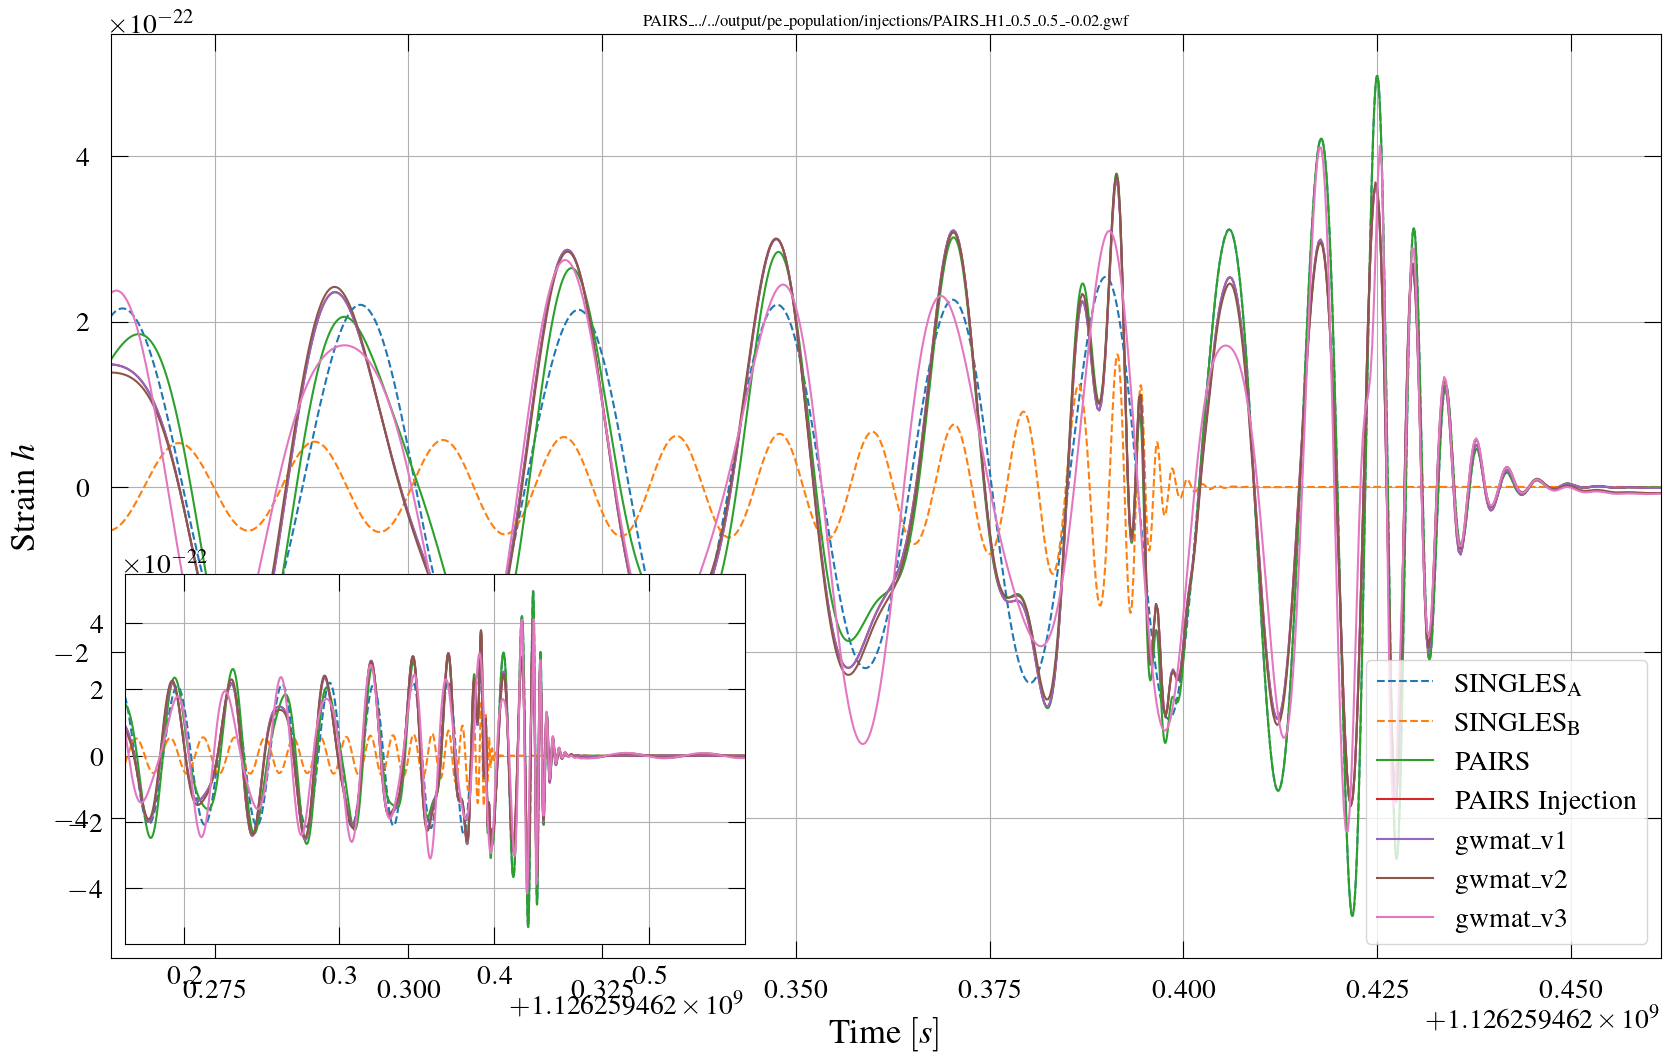

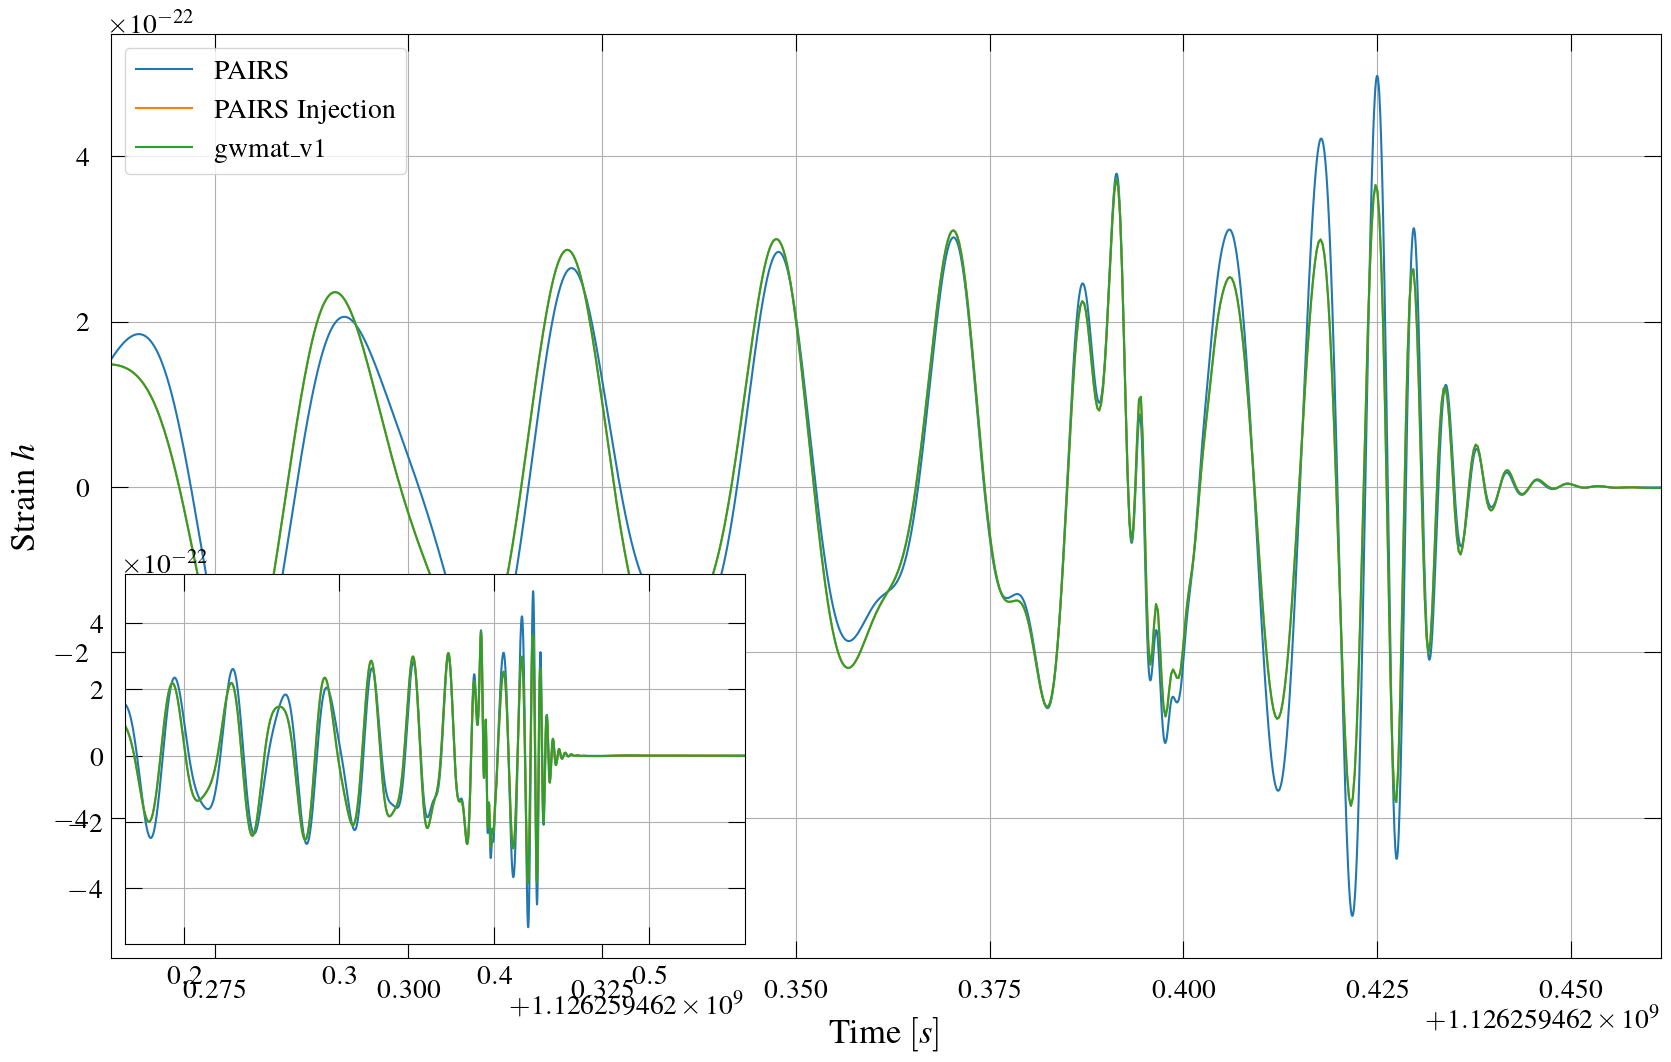

In [6]:
plot(1)

Requested number of samples exceeds the highest available frequency in the input data, will use max available frequency instead. (requested 8191.968750 Hz, available 4995.378000 Hz)
Requested number of samples exceeds the highest available frequency in the input data, will use max available frequency instead. (requested 8191.968750 Hz, available 4995.378000 Hz)


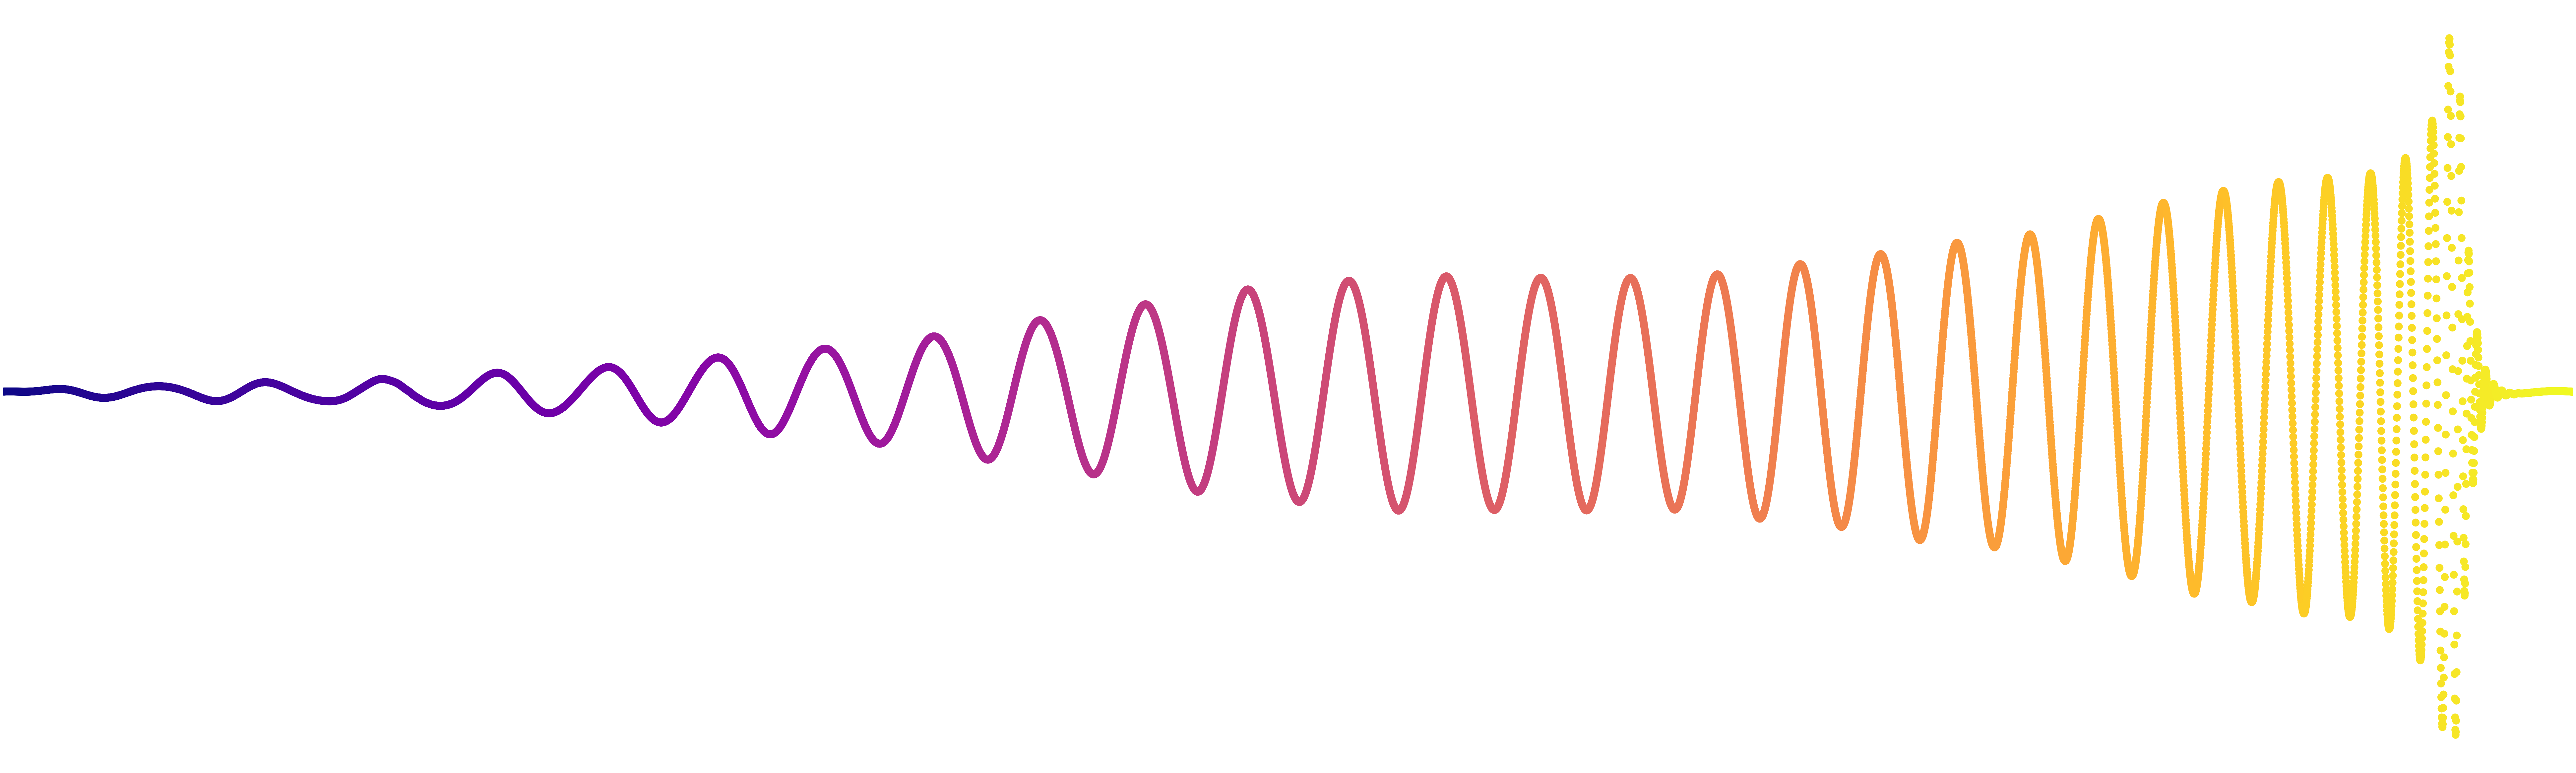

In [32]:
inj_num = 1
inj_dir="../../output/pe_population/injections/"
ifo="H1"
def_kwargs = {"approximant":"IMRPhenomXO4a", "rwrap":-0.3, "delta_t":1/16384, 
                    "taper_hp_hc":True, "hp_hc_extra_padding_at_start":8.0, "delta_f":1/32, 
                    "f_final":16384}
kwargs = deepcopy(def_kwargs)
new_injs_path = glob(inj_dir + "PAIRS*_"+ifo+"_*.gwf")
f=new_injs_path[inj_num]
inj_label = f.split("/PAIRS_"+ifo)[-1].split(".gwf")[0]
inj_pair = read_frame(location=f, channels=ifo+":PyCBC_Injection")
f_1 = glob("../../output/pe_population/injections/SINGLES_A"+inj_label+".npy")[0]
d_1 = np.load(f_1, allow_pickle=True).item()
d_1['sampling_frequency'] = 16384
d_1['delta_t'] = 1/8192
d_1['f_final'] = 16384
wf = gwmat.injection.simulate_injection_with_comprehensive_output(**d_1)
fig, ax = plt.subplots(figsize=(100, 30))
x=wf['pure_polarized_wfs']['hp'].sample_times
y=wf['pure_polarized_wfs']['hp']
mask = np.where((x > float(wf['pure_polarized_wfs']['hp'].start_time)+14.5) & (x < float(wf['pure_polarized_wfs']['hp'].start_time)+15.75))
x = x[mask]
y = y[mask]
sc = ax.scatter(x, y,
                c=x,
                cmap='plasma',
                s=200,
                marker='.',
                linewidths=10)
ax.set_xlim(float(wf['pure_polarized_wfs']['hp'].start_time)+14.5, float(wf['pure_polarized_wfs']['hp'].start_time)+15.75)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.savefig("GW_Waveform.pdf", bbox_inches='tight', dpi=300)
plt.show()